In [143]:
import numpy as np
import pandas as pd
import matplotlib as plt
import geopandas as gpd # conda install geopandas
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point, Polygon
import folium # conda install -c conda-forge folium
import json
import pickle
import geopy
from geopy.extra.rate_limiter import RateLimiter
import re
import requests
import functools

### Import data
We import the dataset containing the food inspection and drop all irrelevant and null columns.

In [144]:
data = pd.read_csv('data/food-inspections.csv', converters = {
                                    'Address' : str.strip,
                                    'DBA Name' : str.strip})#this may delete some rows

These columns "Historical Wards 2003-2015", "Zip Codes", "Community Areas", "Census Tracts" and "Wards" contain only null values.

In [145]:
for s in ["Historical Wards 2003-2015", "Zip Codes", "Community Areas", "Census Tracts", "Wards"]:
    print (data[data["Zip Codes"].isnull()].shape == data.shape)

True
True
True
True
True


Furthermore the columns  'City', 'State' are pointless as we only have data for Chicago.  
The column "Location" is already contained in the "Latitude" and "Longitude" columns

In [146]:
dd = data[data["AKA Name"]!=data["DBA Name"]]

In [147]:
data[data["DBA Name"].isnull()].shape

(0, 22)

In [148]:
data[data["AKA Name"].isnull()].shape

(2452, 22)

In [149]:
dd[dd["AKA Name"].isnull()].shape

(2452, 22)

In [150]:
dd[dd["DBA Name"].str.contains("Burger King")].shape

(11, 22)

In [183]:
data[data["DBA Name"].str.contains("McDonald")]

Inspection ID               DBA Name  License # Facility Type  \
306         2315844.0       McDonald's #4308  1904304.0    Restaurant   
703         2313189.0              McDonalds  1984911.0    Restaurant   
1121        2312696.0              McDonalds  1984911.0    Restaurant   
3219        2304374.0              McDonalds  2031962.0    Restaurant   
9839        2282299.0   McDonalds Restaurant    12886.0    Restaurant   
...               ...                    ...        ...           ...   
191789       246206.0  McDonald's Restaurant  1193659.0    Restaurant   
193308        54243.0  McDonald's Restaurant  1193659.0    Restaurant   
193754        54239.0  McDonald's Restaurant  1193659.0    Restaurant   
194478        68263.0              McDonalds  1770419.0    Restaurant   
194671        68255.0   McDonalds Restaurant    12886.0    Restaurant   

                   Risk                Address      Zip  \
306     Risk 2 (Medium)      3867 S Archer AVE  60632.0   
703     Risk 2 (Medium)      4320 N Cicero AVE  60641.0   
1121    Risk 2 (Medium)      4320 N Cicero AVE  60641.0   
3219    Risk 2 (Medium)         1951 E 95th ST  60617.0   
9839    Risk 2 (Medium)  9211 S COMMERCIAL AVE  60617.0   
...                 ...                    ...      ...   
191789  Risk 2 (Medium)      5015 W MADISON ST  60644.0   
193308  Risk 2 (Medium)      5015 W MADISON ST  60644.0   
193754  Risk 2 (Medium)      5015 W MADISON ST  60644.0   
194478  Risk 2 (Medium)         1951 E 95th ST  60617.0   
194671  Risk 2 (Medium)  9211 S COMMERCIAL AVE  60617.0   

                Inspection Date          Inspection Type             Results  \
306     2019-10-15T00:00:00.000                  Canvass  Pass w/ Conditions   
703     2019-10-02T00:00:00.000  Complaint Re-Inspection                Pass   
1121    2019-09-23T00:00:00.000                Complaint                Fail   
3219    2019-08-08T00:00:00.000  Complaint Re-Inspection                Pass   
9839    2019-03-29T00:00:00.000                Complaint  Pass w/ Conditions   
...                         ...                      ...                 ...   
191789  2010-03-10T00:00:00.000     Short Form Complaint                Pass   
193308  2010-02-05T00:00:00.000    Canvass Re-Inspection                Pass   
193754  2010-01-27T00:00:00.000                  Canvass                Fail   
194478  2010-01-12T00:00:00.000     Short Form Complaint                Pass   
194671  2010-01-08T00:00:00.000     Short Form Complaint  Pass w/ Conditions   

                                               Violations   Latitude  \
306     10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...  41.823158   
703     36. THERMOMETERS PROVIDED & ACCURATE - Comment...  41.959575   
1121    3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.959575   
3219    10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...  41.722354   
9839    2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...  41.727880   
...                                                   ...        ...   
191789                                                NaN  41.880318   
193308                                                NaN  41.880318   
193754  29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...  41.880318   
194478                                                NaN  41.722354   
194671                                                NaN  41.727880   

        Longitude  
306    -87.689237  
703    -87.747646  
1121   -87.747646  
3219   -87.575778  
9839   -87.551061  
...           ...  
191789 -87.750746  
193308 -87.750746  
193754 -87.750746  
194478 -87.575778  
194671 -87.551061  

[153 rows x 13 columns]

stays aka name the same for same address?

In [152]:
data[data["Address"].str.contains("29 E 87TH ST")]

Inspection ID                           DBA Name  \
15796         2240387                         MCDONALD'S   
21183         2185015                         MCDONALD'S   
25512         2166661             DARRINS FRESH FOOD LLC   
27414         2150754                         MCDONALD'S   
29513         2144706                         MCDONALD'S   
34274         2103176             DARRINS FRESH FOOD LLC   
34299         2103180                      POPUP DROPOFF   
36756         1983243                         MCDONALD'S   
46170         1983219                         MCDONALD'S   
46658         2028488                         MCDONALD'S   
51234         1982496                      POPUP DROPOFF   
57245         1966776                         MCDONALD'S   
66329         1932248                         MCDONALD'S   
66548         1932060                      POPUP DROPOFF   
66692         1931905                      POPUP DROPOFF   
67466         1931252                      POPUP DROPOFF   
77314         1386585                   MCDONALD'S #6337   
80075         1583274                      POPUP DROPOFF   
80108         1583280                   FLIPPIN & DIPPIN   
80930         1578735                      POPUP DROPOFF   
81354         1578510                    McDonalds #6337   
81370         1557250                         MCDONALD'S   
86522         1386280                    McDonalds #6337   
86806         1386254                    McDonalds #6337   
94436         1385957                    McDonalds #6337   
94566         1385954                    McDonalds #6337   
106710        1387571                    McDonalds #6337   
125954        1296543                    McDonalds #6337   
131619        1296377                   FLIPPIN & DIPPIN   
132150        1296361                   FLIPPIN & DIPPIN   
137211        1321785                CURRIE BOY CATERING   
145647        1234961                    McDonalds #6337   
146284        1234730                    McDonalds #6337   
159660         545647                    McDonalds #6337   
168096         545398                    McDonalds #6337   
175396         567206                CURRIE BOY CATERING   
175402         567207                CURRIE BOY CATERING   
175403         567208  PORTER GRILL & PREFERRED CATERING   
189487         238270                         MCDONALD'S   
189533         238271                    McDonalds #6337   

                                 AKA Name  License # Facility Type  \
15796                          MCDONALD'S  2428106.0    Restaurant   
21183                          MCDONALD'S  2428106.0    Restaurant   
25512              DARRINS FRESH FOOD LLC  2563982.0    Restaurant   
27414                          MCDONALD'S  2428106.0    Restaurant   
29513                          MCDONALD'S  2428106.0    Restaurant   
34274              DARRINS FRESH FOOD LLC  2563982.0    Restaurant   
34299                       POPUP DROPOFF  2428698.0    Restaurant   
36756                          MCDONALD'S  2428106.0    Restaurant   
46170                          MCDONALD'S  2428106.0    Restaurant   
46658                          MCDONALD'S  2428106.0    Restaurant   
51234                       POPUP DROPOFF  2428698.0    Restaurant   
57245                          MCDONALD'S  2428106.0    Restaurant   
66329                          MCDONALD'S  2428106.0    Restaurant   
66548                       POPUP DROPOFF  2428698.0    Restaurant   
66692                       POPUP DROPOFF  2428698.0    Restaurant   
67466                       POPUP DROPOFF  2428698.0    Restaurant   
77314                    MCDONALD'S #6337  1768801.0    Restaurant   
80075                       POPUP DROPOFF  2428698.0    Restaurant   
80108                    FLIPPIN & DIPPIN  2253130.0    Restaurant   
80930                       POPUP DROPOFF  2428698.0    Restaurant   
81354                      McDonalds#6337  1768801.0    Restaurant   
81370  

Name not consistend

We drop the "AKA Name" column it contains null value and does not much differ from the DBA name column.

In [153]:
#TODO same restaurant changes in name, some addresses contain too many whitespaces...

Therefore we will drop all the before mentioned columns.

In [154]:
data = data.drop(['AKA Name', 'City', 'State', "Historical Wards 2003-2015", "Zip Codes", "Community Areas", "Census Tracts", "Wards", "Location"], axis=1)

In [155]:
data.head()

Inspection ID                                DBA Name  License #  \
0        2320509                      TAQUERIA EL DORADO  2694960.0   
1        2320519                       SALAM  RESTAURANT  2002822.0   
2        2320421                THE NEW GRACE RESTAURANT  2698310.0   
3        2320368             GADS HILL CHILD CARE CENTER  2215799.0   
4        2320389  ALL THINGS ARE POSSIBLE FOR KIDS, INC.  2215965.0   

                  Facility Type           Risk                 Address  \
0                    Restaurant  Risk 1 (High)     2114 W LAWRENCE AVE   
1                    Restaurant  Risk 1 (High)  4634-4636 N KEDZIE AVE   
2                    Restaurant  Risk 1 (High)         4409 N BROADWAY   
3  Children's Services Facility  Risk 1 (High)        2653 W OGDEN AVE   
4  Children's Services Facility  Risk 1 (High)      4014 W CHICAGO AVE   

       Zip          Inspection Date          Inspection Type    Results  \
0  60625.0  2019-10-25T00:00:00.000    License Re-Inspection       Fail   
1  60625.0  2019-10-25T00:00:00.000  Complaint Re-Inspection       Pass   
2  60640.0  2019-10-24T00:00:00.000                  License  Not Ready   
3  60608.0  2019-10-24T00:00:00.000                  License       Pass   
4  60651.0  2019-10-24T00:00:00.000                  License       Pass   

                                          Violations   Latitude  Longitude  
0  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968820 -87.682292  
1                                                NaN  41.965719 -87.708538  
2                                                NaN  41.962104 -87.655204  
3  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...  41.862273 -87.692703  
4  54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILI...  41.895468 -87.726665

In [156]:
data = data.replace("  *", " ", regex = True) #remove double whitespaces

In [157]:
data[data["Address"] == ""] #are the same as before stripping

Inspection ID                    DBA Name  License # Facility Type  \
69601         1763245  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
189113         114452              Starfruit Cafe  2031651.0           NaN   
190589          60405      CASA CENTRAL LA POSADA        0.0    Restaurant   

                   Risk Address      Zip          Inspection Date  \
69601     Risk 1 (High)              NaN  2016-04-19T00:00:00.000   
189113  Risk 2 (Medium)          60654.0  2010-05-05T00:00:00.000   
190589    Risk 1 (High)              NaN  2010-04-05T00:00:00.000   

       Inspection Type    Results  \
69601          License  Not Ready   
189113         License       Fail   
190589         Canvass       Pass   

                                               Violations  Latitude  Longitude  
69601                                                 NaN       NaN        NaN  
189113                                                NaN       NaN        NaN  
190589  37. TOILET ROOM DOORS SELF CLOSING: DRESSING R...       NaN        NaN

# Complete the dataset

## Duplicates
Entries must be identified by their Inspection ID. Duplicate rows can simply be removed.

In [158]:
print("Number of duplicate inspection IDs: " + str(len(data[data.duplicated("Inspection ID")])))
data = data.drop_duplicates()
print("Number of duplicate inspection IDs after removal: " + str(len(data[data.duplicated("Inspection ID")])))

Number of duplicate inspection IDs: 196
Number of duplicate inspection IDs after removal: 0


## Deal with missing values

For every column we will look at the number of entries with data that is missing/null.

In [159]:
for col in data.columns:
    print("Number of null entries for " + col + ":" + str(len(data[data[col].apply(pd.isnull)])))
    if isinstance(data[col][0], str):
        print("Number of empty string entries for " + col + ":" + str(len(data[data[col].apply(str).apply(str.isspace)])))

Number of null entries for Inspection ID:0
Number of null entries for DBA Name:0
Number of empty string entries for DBA Name:0
Number of null entries for License #:17
Number of null entries for Facility Type:4770
Number of empty string entries for Facility Type:0
Number of null entries for Risk:72
Number of empty string entries for Risk:0
Number of null entries for Address:0
Number of empty string entries for Address:0
Number of null entries for Zip:50
Number of null entries for Inspection Date:0
Number of empty string entries for Inspection Date:0
Number of null entries for Inspection Type:1
Number of empty string entries for Inspection Type:0
Number of null entries for Results:0
Number of empty string entries for Results:0
Number of null entries for Violations:51636
Number of empty string entries for Violations:0
Number of null entries for Latitude:682
Number of null entries for Longitude:682


The two columns with the most missing data are "Facility Type" and "Violations".

### Address
There are some addresses that are missing in that they only contain a few spaces.

In [160]:
data[data['Address'] == ""]

Inspection ID                    DBA Name  License # Facility Type  \
69601         1763245  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
189113         114452              Starfruit Cafe  2031651.0           NaN   
190589          60405      CASA CENTRAL LA POSADA        0.0    Restaurant   

                   Risk Address      Zip          Inspection Date  \
69601     Risk 1 (High)              NaN  2016-04-19T00:00:00.000   
189113  Risk 2 (Medium)          60654.0  2010-05-05T00:00:00.000   
190589    Risk 1 (High)              NaN  2010-04-05T00:00:00.000   

       Inspection Type    Results  \
69601          License  Not Ready   
189113         License       Fail   
190589         Canvass       Pass   

                                               Violations  Latitude  Longitude  
69601                                                 NaN       NaN        NaN  
189113                                                NaN       NaN        NaN  
190589  37. TOILET ROOM DOORS SELF CLOSING: DRESSING R...       NaN        NaN

In [161]:
data[data['DBA Name'].str.contains("CASA CENTRAL LA")]

Inspection ID                DBA Name  License # Facility Type  \
190589          60405  CASA CENTRAL LA POSADA        0.0    Restaurant   

                 Risk Address  Zip          Inspection Date Inspection Type  \
190589  Risk 1 (High)          NaN  2010-04-05T00:00:00.000         Canvass   

       Results                                         Violations  Latitude  \
190589    Pass  37. TOILET ROOM DOORS SELF CLOSING: DRESSING R...       NaN   

        Longitude  
190589        NaN

Google Maps: Casa Central, 1343 N California Ave
Does not match, will drop this one.

In [162]:
data = data.drop(190589)

In [163]:
data[data['DBA Name'].str.contains("EAT N RUN")]

Inspection ID                    DBA Name  License # Facility Type  \
15361        2240854  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
34286        2103165  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
35481        2099037  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
59935        1960561  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
69601        1763245  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   

                Risk             Address      Zip          Inspection Date  \
15361  Risk 1 (High)  8233 S ASHLAND AVE  60620.0  2018-11-29T00:00:00.000   
34286  Risk 1 (High)  8233 S ASHLAND AVE  60620.0  2017-11-03T00:00:00.000   
35481  Risk 1 (High)  8233 S ASHLAND AVE  60620.0  2017-10-17T00:00:00.000   
59935  Risk 1 (High)  8233 S ASHLAND AVE  60620.0  2016-09-13T00:00:00.000   
69601  Risk 1 (High)                          NaN  2016-04-19T00:00:00.000   

      Inspection Type          Results  \
15361         Canvass  Out of Business   
34286         Canvass         No Entry   
35481         Canvass         No Entry   
59935         License             Pass   
69601         License        Not Ready   

                                              Violations   Latitude  Longitude  
15361                                                NaN  41.743903 -87.663129  
34286                                                NaN  41.743903 -87.663129  
35481                                                NaN  41.743903 -87.663129  
59935  35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...  41.743903 -87.663129  
69601                                                NaN        NaN        NaN

We will update the data.

In [164]:
data.at[69601,"Address"] = "EAT N RUN CHICKEN AND FISH"
data.at[69601,"Latitude"] = 41.884250
data.at[69601,"Longitude"]= -87.632450
data.at[69601,"Zip"]= 60620.0

In [165]:
data[data['DBA Name'].str.contains("EAT N RUN")]

Inspection ID                    DBA Name  License # Facility Type  \
15361        2240854  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
34286        2103165  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
35481        2099037  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
59935        1960561  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   
69601        1763245  EAT N RUN CHICKEN AND FISH  2442868.0    Restaurant   

                Risk                     Address      Zip  \
15361  Risk 1 (High)          8233 S ASHLAND AVE  60620.0   
34286  Risk 1 (High)          8233 S ASHLAND AVE  60620.0   
35481  Risk 1 (High)          8233 S ASHLAND AVE  60620.0   
59935  Risk 1 (High)          8233 S ASHLAND AVE  60620.0   
69601  Risk 1 (High)  EAT N RUN CHICKEN AND FISH  60620.0   

               Inspection Date Inspection Type          Results  \
15361  2018-11-29T00:00:00.000         Canvass  Out of Business   
34286  2017-11-03T00:00:00.000         Canvass         No Entry   
35481  2017-10-17T00:00:00.000         Canvass         No Entry   
59935  2016-09-13T00:00:00.000         License             Pass   
69601  2016-04-19T00:00:00.000         License        Not Ready   

                                              Violations   Latitude  Longitude  
15361                                                NaN  41.743903 -87.663129  
34286                                                NaN  41.743903 -87.663129  
35481                                                NaN  41.743903 -87.663129  
59935  35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...  41.743903 -87.663129  
69601                                                NaN  41.884250 -87.632450

In [166]:
data[data['DBA Name'].str.contains("Starfruit Cafe")]

Inspection ID        DBA Name  License # Facility Type  \
189113         114452  Starfruit Cafe  2031651.0           NaN   

                   Risk Address      Zip          Inspection Date  \
189113  Risk 2 (Medium)          60654.0  2010-05-05T00:00:00.000   

       Inspection Type Results Violations  Latitude  Longitude  
189113         License    Fail        NaN       NaN        NaN

Google maps: The "Starfruit Cafe" is also closed now, Address: "2142 N Halsted St", "IL 60614" But the zip code is different. 
So will drop this one as well.

In [167]:
data = data.drop(189113)

### Latitude and longitude
There are entries that are missing coordinate data, which is needed to put them on the map.
We see that all entries have address data, so we try to fill in the null values for the coordinates by using Geopy that uses geocoders to get coordinates based on addresses. Through testing we found that using ArcGIS as a geocoder gives us a perfect result.

In [176]:
locator = geopy.geocoders.ArcGIS(user_agent='myGeocoder')
data_wo_latlong = data[data['Latitude'].apply(np.isnan)].groupby("DBA Name").first()
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
lats = pd.Series(index=data_wo_latlong.index)
longs = pd.Series(index=data_wo_latlong.index)
for name, address in list(zip(data_wo_latlong.index, data_wo_latlong['Address'])):
    if str.isspace(address):
        print('Empty address for ' + name + 'ignored')
        continue
    location = geocode(address + ", Chicago, United States")
    if location is not None:
        lats[name] = location.latitude
        longs[name] = location.longitude
    else:
        print('Did not find location for address: ' + address)

for name, lat, long in zip(lats.index, lats, longs):
    data['Latitude'] = np.where(data['DBA Name'] == name, lat, data['Latitude'])
    data['Longitude'] = np.where(data['DBA Name'] == name, long, data['Longitude'])

In [177]:
print("Number of entries without coordinate data: " + str(len(data[data["Latitude"].apply(pd.isnull)])))
data[data["Latitude"].apply(pd.isnull)]

Number of entries without coordinate data: 0


Empty DataFrame
Columns: [Inspection ID, DBA Name, License #, Facility Type, Risk, Address, Zip, Inspection Date, Inspection Type, Results, Violations, Latitude, Longitude]
Index: []

In [179]:
data.to_pickle("./data/data_withgeo.pkl")

### Zip
We supplement the zip codes by finding where the coordinates belong in a GeoJSON boundary map for zip codes.

In [170]:
data[data['Zip'].apply(pd.isnull)].sample(10)

Inspection ID                                    DBA Name  License #  \
116370        1396156                          THINK SIMPLE FOODS  2308286.0   
84837         1562130             PARKWEST LIQUORS AND SMOKE SHOP  2354157.0   
18421         2222692                       LEO'S FOOD AND LIQUOR  2535068.0   
124446        1115029                 SPORT SERVICE SOLDIER FIELD  1354323.0   
94047         1523196                           BURGER KING #1310  2232344.0   
20750         2200428                       LEO'S FOOD AND LIQUOR  2535068.0   
174129         525238                       THE LUNCH MACHINE INC  2079077.0   
169362         598237  SPORT SERVICE SOLDIER FIELD/SUITE PANTRY D  1354323.0   
116680        1396011                          THINK SIMPLE FOODS  2308286.0   
179803         335363               TISH'S TINY TOWN FOR TOTS CHI  1887746.0   

                Facility Type             Risk                   Address  Zip  \
116370             Restaurant  Risk 2 (Medium)         141 W CHICAGO AVE  NaN   
84837                  Liquor     Risk 3 (Low)        2570 N LINCOLN AVE  NaN   
18421                  Liquor     Risk 3 (Low)       4471 W LAWRENCE AVE  NaN   
124446             Restaurant  Risk 2 (Medium)  1410 S MUSEUM CAMPUS DR.  NaN   
94047              Restaurant  Risk 2 (Medium)  2320-2322 S MICHIGAN AVE  NaN   
20750                  Liquor     Risk 3 (Low)       4471 W LAWRENCE AVE  NaN   
174129  Mobile Food Dispenser  Risk 2 (Medium)         1319 W WILSON AVE  NaN   
169362             Restaurant  Risk 2 (Medium)  1410 S MUSEUM CAMPUS DR.  NaN   
116680             Restaurant  Risk 2 (Medium)         141 W CHICAGO AVE  NaN   
179803                    NaN    Risk 1 (High)            2301 E 79TH ST  NaN   

                Inspection Date        Inspection Type             Results  \
116370  2014-02-11T00:00:00.000  License Re-Inspection                Pass   
84837   2015-08-12T00:00:00.000                License                Fail   
18421   2018-09-21T00:00:00.000                License  Pass w/ Conditions   
124446  2013-09-19T00:00:00.000                Canvass     Out of Business   
94047   2015-02-23T00:00:00.000                Canvass     Out of Business   
20750   2018-08-02T00:00:00.000                License           Not Ready   
174129  2011-03-01T00:00:00.000  License Re-Inspection                Fail   
169362  2011-05-24T00:00:00.000                Canvass                Pass   
116680  2014-02-06T00:00:00.000                License                Fail   
179803  2010-10-25T00:00:00.000                License                Fail   

                                               Violations   Latitude  \
116370                                                NaN  41.896504   
84837   12. HAND WASHING FACILITIES: WITH SOAP AND SAN...  41.928597   
18421   3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.967993   
124446                                                NaN  41.862240   
94047                                                 NaN  41.850454   
20750                                                 NaN  41.967993   
174129                                                NaN  41.965212   
169362                                                NaN  41.862628   
116680  16. FOOD PROTECTED DURING STORAGE, PREPARATION...  41.896504   
179803                                                NaN  41.751592   

        Longitude  
116370 -87.632784  
84837  -87.653388  
18421  -87.740726  
124446 -87.616701  
94047  -87.623891  
20750  -87.740726  
174129 -87.663260  
169362 -87.615031  
116680 -87.632784  
179803 -87.568606

In [171]:
map_zip = gpd.read_file('data/chicago_zip.geojson')
missing_zip = data[data['Zip'].apply(pd.isnull)].copy()
for index, lat, long in zip(missing_zip.index, missing_zip['Latitude'], missing_zip['Longitude']):
    for zip_code, mpoly in zip(map_zip.zip, map_zip.geometry): 
        for poly in mpoly:
            if poly.contains(Point(long,lat)): # Points in polygons have inverse lat, long
                missing_zip.at[index,'Zip'] = zip_code
data.update(missing_zip)

print("Number of entries without zip data: " + str(len(data[data['Zip'].apply(pd.isnull)])))
data[data['Zip'].apply(pd.isnull)]

Number of entries without zip data: 1


Inspection ID                   DBA Name  License # Facility Type  \
123931      1106878.0  FILIPINO AMERICAN COUNCIL  2225427.0  Golden Diner   

                 Risk                        Address  Zip  \
123931  Risk 1 (High)  1332 W DRIVING PARK ROAD BSMT  NaN   

                Inspection Date Inspection Type          Results Violations  \
123931  2013-09-26T00:00:00.000         Canvass  Out of Business        NaN   

        Latitude  Longitude  
123931  39.94981  -82.95809

TODO: get ZIP here

### License number
We decide that license numbers are not important for our research. There are only 17 entires without it. Most of them are churches or Special Evnets

In [172]:
data[data['License #'].apply(pd.isnull)].head(20)

Inspection ID                                      DBA Name  \
6403        2290863.0           ST. DEMETRIOS GREEK ORTHODOX CHURCH   
22844       2181316.0           ST. DEMETRIOS GREEK ORTHODOX CHURCH   
39837       2071910.0           ST. DEMETRIOS GREEK ORTHODOX CHURCH   
65373       1933084.0           ST. DEMETRIOS GREEK ORTHODOX CHURCH   
85255       1561809.0           ST. DEMETRIOS GREEK ORTHODOX CHURCH   
110647      1459918.0           ST. DEMETRIOS GREEK ORTHODOX CHURCH   
113188      1152076.0                               ARGENTINA FOODS   
127949      1099104.0           ST. DEMETRIOS GREEK ORTHODOX CHURCH   
147647      1188285.0           ST. DEMETRIOS GREEK ORTHODOX CHURCH   
151045      1184330.0                      OLD ST. PATRICK'S CHURCH   
154371      1214242.0               GOD'S BATTLE AXE PRAYER ACADEMY   
154583       679787.0               GOD'S BATTLE AXE PRAYER ACADEMY   
156097       670328.0               GOD'S BATTLE AXE PRAYER ACADEMY   
165344       521659.0           ST. DEMETRIOS GREEK ORTHODOX CHURCH   
176442       417318.0  AVALON COMMUNITY CHURCH/FREEDOM HOME ACADEMY   
184679       339207.0                           ST DEMETRIOS CHURCH   
187278       229453.0                      OLD ST. PATRICK'S CHURCH   

        License #                Facility Type             Risk  \
6403          NaN                Special Event  Risk 2 (Medium)   
22844         NaN                Special Event  Risk 2 (Medium)   
39837         NaN                Special Event  Risk 2 (Medium)   
65373         NaN                Special Event  Risk 2 (Medium)   
85255         NaN                Special Event  Risk 2 (Medium)   
110647        NaN                Special Event  Risk 2 (Medium)   
113188        NaN                Grocery Store  Risk 2 (Medium)   
127949        NaN                Special Event  Risk 2 (Medium)   
147647        NaN                Special Event  Risk 2 (Medium)   
151045        NaN                       Church  Risk 2 (Medium)   
154371        NaN              CHURCH/DAY CARE    Risk 1 (High)   
154583        NaN              CHURCH/DAY CARE    Risk 1 (High)   
156097        NaN              CHURCH/DAY CARE    Risk 1 (High)   
165344        NaN                Special Event  Risk 2 (Medium)   
176442        NaN  CHURCH/AFTER SCHOOL PROGRAM    Risk 1 (High)   
184679        NaN                Special Event    Risk 1 (High)   
187278        NaN                       Church  Risk 2 (Medium)   

                   Address      Zip          Inspection Date  \
6403      2727 W WINONA ST  60625.0  2019-06-04T00:00:00.000   
22844     2727 W WINONA ST  60625.0  2018-06-13T00:00:00.000   
39837     2727 W WINONA ST  60625.0  2017-08-04T00:00:00.000   
65373     2727 W WINONA ST  60625.0  2016-06-20T00:00:00.000   
85255     2727 W WINONA ST  60625.0  2015-08-04T00:00:00.000   
110647    2727 W WINONA ST  60625.0  2014-05-20T00:00:00.000   
113188      4500 S WOOD ST  60609.0  2014-04-10T00:00:00.000   
127949    2727 W WINONA ST  60625.0  2013-07-24T00:00:00.000   
147647    2727 W WINONA ST  60625.0  2012-07-25T00:00:00.000   
151045      700 W ADAMS ST  60661.0  2012-05-22T00:00:00.000   
154371  6969 N WESTERN AVE  60645.0  2012-03-19T00:00:00.000   
154583  6969 N WESTERN AVE  60645.0  2012-03-14T00:00:00.000   
156097  6969 N WESTERN AVE  60645.0  2012-02-09T00:00:00.000   
165344    2727 W WINONA ST  60625.0  2011-08-10T00:00:00.000   
176442    8100 S DANTE AVE  60619.0  2011-01-10T00:00:00.000   
184679    2727 W WINONA ST  60625.0  2010-07-30T00:00:00.000   
187278      700 W ADAMS ST  60661.0  2010-06-08T00:00:00.000   

                   Inspection Type             Results  \
6403                       Canvass  Pass w/ Conditions   
22844                      Canvass                Pass   
39837                      Canvass                Pass   
65373                      Canvass                Pass   
85255                      Canvass                Pass   
110647               

"ST. DEMETRIOS GREEK ORTHODOX CHURCH" has in no entry a license number.

In [173]:
data[data['DBA Name'] == 'ST. DEMETRIOS GREEK ORTHODOX CHURCH']

Inspection ID                             DBA Name  License #  \
6403        2290863.0  ST. DEMETRIOS GREEK ORTHODOX CHURCH        NaN   
22844       2181316.0  ST. DEMETRIOS GREEK ORTHODOX CHURCH        NaN   
39837       2071910.0  ST. DEMETRIOS GREEK ORTHODOX CHURCH        NaN   
65373       1933084.0  ST. DEMETRIOS GREEK ORTHODOX CHURCH        NaN   
85255       1561809.0  ST. DEMETRIOS GREEK ORTHODOX CHURCH        NaN   
110647      1459918.0  ST. DEMETRIOS GREEK ORTHODOX CHURCH        NaN   
127949      1099104.0  ST. DEMETRIOS GREEK ORTHODOX CHURCH        NaN   
147647      1188285.0  ST. DEMETRIOS GREEK ORTHODOX CHURCH        NaN   
165344       521659.0  ST. DEMETRIOS GREEK ORTHODOX CHURCH        NaN   

        Facility Type             Risk           Address      Zip  \
6403    Special Event  Risk 2 (Medium)  2727 W WINONA ST  60625.0   
22844   Special Event  Risk 2 (Medium)  2727 W WINONA ST  60625.0   
39837   Special Event  Risk 2 (Medium)  2727 W WINONA ST  60625.0   
65373   Special Event  Risk 2 (Medium)  2727 W WINONA ST  60625.0   
85255   Special Event  Risk 2 (Medium)  2727 W WINONA ST  60625.0   
110647  Special Event  Risk 2 (Medium)  2727 W WINONA ST  60625.0   
127949  Special Event  Risk 2 (Medium)  2727 W WINONA ST  60625.0   
147647  Special Event  Risk 2 (Medium)  2727 W WINONA ST  60625.0   
165344  Special Event  Risk 2 (Medium)  2727 W WINONA ST  60625.0   

                Inspection Date Inspection Type             Results  \
6403    2019-06-04T00:00:00.000         Canvass  Pass w/ Conditions   
22844   2018-06-13T00:00:00.000         Canvass                Pass   
39837   2017-08-04T00:00:00.000         Canvass                Pass   
65373   2016-06-20T00:00:00.000         Canvass                Pass   
85255   2015-08-04T00:00:00.000         Canvass                Pass   
110647  2014-05-20T00:00:00.000         Canvass                Pass   
127949  2013-07-24T00:00:00.000         Canvass                Pass   
147647  2012-07-25T00:00:00.000         Canvass                Pass   
165344  2011-08-10T00:00:00.000         Canvass                Pass   

                                               Violations   Latitude  \
6403    3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.974653   
22844   32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...  41.974653   
39837   32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...  41.974653   
65373   38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...  41.974653   
85255                                                 NaN  41.974653   
110647  33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...  41.974653   
127949  32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...  41.974653   
147647  33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...  41.974653   
165344                                                NaN  41.974653   

        Longitude  
6403   -87.697529  
22844  -87.697529  
39837  -87.697529  
65373  -87.697529  
85255  -87.697529  
110647 -87.697529  
127949 -87.697529  
147647 -87.697529  
165344 -87.697529

As we will never use the "License #" column we will drop it entirely. 

In [174]:
#data = data.drop(["License #"], axis=1)

In [175]:
#data.head()

### Facility Type
There are a lot of missing facility types.

In [62]:
null_facility = data[data['Facility Type'].apply(pd.isnull)]
null_facility

Inspection ID                                       DBA Name  \
137         2316135.0                                          SHELL   
171         2316086.0                 UNIVERSITY CENTER PROPERTY LLC   
242         2316011.0                        DASH OF SALT AND PEPPER   
275         2315957.0                                G & J ICE CREAM   
296         2315960.0                               MINGHIN JAPENESE   
...               ...                                            ...   
194823       120276.0                                         BUTTER   
194841       160208.0  LOVEBUGS, TODDLER PROGRAMS AND PRESCHOOL, LLC   
194861        70272.0                                   THE DOGHOUSE   
194862        67760.0                                    MC INTOSH'S   
194885        74258.0                                     MAKIA FOOD   

        License # Facility Type             Risk                    Address  \
137     2889767.0           NaN     Risk 3 (Low)      6659 S WENTWORTH AVE    
171     2694616.0           NaN              NaN            525 S STATE ST    
242     2694886.0           NaN    Risk 1 (High)        2201 N LINCOLN AVE    
275     2622621.0           NaN  Risk 2 (Medium)        6355 S WESTERN AVE    
296     2670193.0           NaN              NaN  1232-1234 S MICHIGAN AVE    
...           ...           ...              ...                        ...   
194823  1193256.0           NaN     Risk 3 (Low)            130 S GREEN ST    
194841  1820997.0           NaN    Risk 1 (High)        1327 N LARRABEE ST    
194861  1681450.0           NaN    Risk 1 (High)         11601 W TOUHY AVE    
194862  1648623.0           NaN    Risk 1 (High)             748 W 61ST ST    
194885  2009488.0           NaN     Risk 3 (Low)     2458 S CALIFORNIA AVE    

            Zip          Inspection Date        Inspection Type    Results  \
137     60621.0  2019-10-18T00:00:00.000                License  Not Ready   
171     60605.0  2019-10-18T00:00:00.000                License  Not Ready   
242     60614.0  2019-10-17T00:00:00.000                License  Not Ready   
275     60636.0  2019-10-16T00:00:00.000                License  Not Ready   
296     60605.0  2019-10-15T00:00:00.000                License  Not Ready   
...         ...                      ...                    ...        ...   
194823  60607.0  2010-01-06T00:00:00.000        Out of Business       Pass   
194841  60610.0  2010-01-05T00:00:00.000        Out of Business       Pass   
194861  60666.0  2010-01-05T00:00:00.000        Out of Business       Pass   
194862  60621.0  2010-01-05T00:00:00.000        Out of Business       Fail   
194885  60608.0  2010-01-05T00:00:00.000  License Re-Inspection       Pass   

       Violations   Latitude  Longitude  
137           NaN  41.772809 -87.629820  
171           NaN  41.875179 -87.627474  
242           NaN  41.922056 -87.643811  
275           NaN  41.777509 -87.683450  
296           NaN  41.866541 -87.624281  
...           ...        ...        ...  
194823        NaN  41.879501 -87.648608  
194841        NaN  41.905866 -87.643136  
194861        NaN  42.008536 -87.914428  
194862        NaN  41.783503 -87.644386  
194885        NaN  41.846516 -87.695423  

[4770 rows x 13 columns]

Merge on "License #"?

In [180]:
data[data["License #"] == 2889767.0]

Inspection ID DBA Name  License # Facility Type          Risk  \
137      2316135.0    SHELL  2889767.0           NaN  Risk 3 (Low)   

                  Address      Zip          Inspection Date Inspection Type  \
137  6659 S WENTWORTH AVE  60621.0  2019-10-18T00:00:00.000         License   

       Results Violations   Latitude  Longitude  
137  Not Ready        NaN  41.772809  -87.62982

In [182]:
data[data["DBA Name"] == "THE DOGHOUSE"] #License Number changed?

Inspection ID      DBA Name  License # Facility Type           Risk  \
166244       539360.0  THE DOGHOUSE  1905364.0           NaN   Risk 3 (Low)   
194861        70272.0  THE DOGHOUSE  1681450.0           NaN  Risk 1 (High)   

                  Address      Zip          Inspection Date  Inspection Type  \
166244  11601 W TOUHY AVE  60666.0  2011-07-25T00:00:00.000          Canvass   
194861  11601 W TOUHY AVE  60666.0  2010-01-05T00:00:00.000  Out of Business   

                Results Violations   Latitude  Longitude  
166244  Out of Business        NaN  42.008536 -87.914428  
194861             Pass        NaN  42.008536 -87.914428

In [181]:
data[data["License #"] == 1681450.0]

Inspection ID      DBA Name  License # Facility Type           Risk  \
194861        70272.0  THE DOGHOUSE  1681450.0           NaN  Risk 1 (High)   

                  Address      Zip          Inspection Date  Inspection Type  \
194861  11601 W TOUHY AVE  60666.0  2010-01-05T00:00:00.000  Out of Business   

       Results Violations   Latitude  Longitude  
194861    Pass        NaN  42.008536 -87.914428

In [79]:
null_facility.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located      26
Fail                     367
No Entry                  71
Not Ready                 89
Out of Business         3915
Pass                     260
Pass w/ Conditions        42
Name: Count, dtype: int64

As we have shown with examples the "Facility Type" is even not available for establishments with several inspections. Most of them seem to be Out of Business. 
Inferring the Facility Type from the name is difficult as well. What Type would "UNIVERSITY CENTER PROPERTY LLC" be. 
Therefore we decided to leave these values.

### Risk

In [80]:
null_risk = data[data['Risk'].apply(pd.isnull)]
null_risk

Inspection ID                               DBA Name  License #  \
171         2316086.0         UNIVERSITY CENTER PROPERTY LLC  2694616.0   
296         2315960.0                       MINGHIN JAPENESE  2670193.0   
930         2312988.0                 COTTAGE GROVE FOOD LLC  2677374.0   
1300        2312532.0       CHICAGO MERCANTILE EXCHANGE INC.  2690163.0   
1681        2312059.0                            CRAFTY CAFE  2689277.0   
...               ...                                    ...        ...   
190454       150313.0                        JO JO FOOD MART  1868927.0   
190872        58405.0                            SOCIAL CLUB        0.0   
191212        58385.0                            SOCIAL CLUB        0.0   
191959        58356.0                            SOCIAL CLUB        0.0   
192096        58348.0  UNIVERSITY OF AESTHETICS/TOUCH CLINIC        0.0   

       Facility Type Risk                    Address      Zip  \
171              NaN  NaN            525 S STATE ST   60605.0   
296              NaN  NaN  1232-1234 S MICHIGAN AVE   60605.0   
930              NaN  NaN      8207 S COTTAGE GROVE   60619.0   
1300             NaN  NaN            20 S WACKER DR   60606.0   
1681      Restaurant  NaN           225 W WACKER DR   60606.0   
...              ...  ...                        ...      ...   
190454           NaN  NaN         3801 N CICERO AVE   60641.0   
190872           NaN  NaN     1105 N CALIFORNIA AVE   60622.0   
191212           NaN  NaN     1105 N CALIFORNIA AVE   60622.0   
191959           NaN  NaN     1105 N CALIFORNIA AVE   60622.0   
192096           NaN  NaN      1357 N MILWAUKEE AVE   60622.0   

                Inspection Date       Inspection Type    Results Violations  \
171     2019-10-18T00:00:00.000               License  Not Ready        NaN   
296     2019-10-15T00:00:00.000               License  Not Ready        NaN   
930     2019-09-26T00:00:00.000               License   No Entry        NaN   
1300    2019-09-18T00:00:00.000               License  Not Ready        NaN   
1681    2019-09-11T00:00:00.000               License  Not Ready        NaN   
...                         ...                   ...        ...        ...   
190454  2010-04-07T00:00:00.000       Out of Business       Pass        NaN   
190872  2010-03-29T00:00:00.000  Short Form Complaint       Pass        NaN   
191212  2010-03-22T00:00:00.000  Short Form Complaint       Pass        NaN   
191959  2010-03-08T00:00:00.000  Short Form Complaint       Pass        NaN   
192096  2010-03-04T00:00:00.000  Short Form Complaint       Pass        NaN   

         Latitude  Longitude  
171     41.875179 -87.627474  
296     41.866541 -87.624281  
930     41.745539 -87.604930  
1300    41.881564 -87.637160  
1681    41.886709 -87.634711  
...           ...        ...  
190454  41.949826 -87.747058  
190872  41.901286 -87.696692  
191212  41.901286 -87.696692  
191959  41.901286 -87.696692  
192096  41.906596 -87.671323  

[72 rows x 13 columns]

In [169]:
null_risk.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located     8
Fail                    22
No Entry                 7
Not Ready               20
Out of Business          3
Pass                    12
Name: Count, dtype: int64

In [170]:
null_risk.groupby('Facility Type').count().rename(columns={"DBA Name": "Count"})["Count"]

Facility Type
AFTER SCHOOL PROGRAM     1
CHICAGO PARK DISTRICT    1
CHURCH                   1
FARMER'S MARKET          1
FOOD PANTRY/CHURCH       2
Illegal Vendor           1
Mobile Food Dispenser    1
RETAIL                   1
Restaurant               5
WAREHOUSE                1
unlicensed facility      2
Name: Count, dtype: int64

In [185]:
#Although for McDonalds it is always the same value. So maybe it can be inferred.

There is no way of knowing what the risk would have been. Therefore we just leave this values as null.

### Inspection Type

In [171]:
data[data['Inspection Type'].apply(pd.isnull)]

Inspection ID         DBA Name  License # Facility Type           Risk  \
63843      1946612.0  ARAMARL-FRESHII  2470318.0    Restaurant  Risk 1 (High)   

                Address      Zip          Inspection Date Inspection Type  \
63843  2650 N CLARK ST   60614.0  2016-07-14T00:00:00.000             NaN   

      Results Violations   Latitude  Longitude Facility Type Group  \
63843    Pass        NaN  41.930833 -87.644135          restaurant   

      Results Group  
63843          pass

### Violations
Since there is no way we can know which violations have been done, we fill null values with "No data".

In [172]:
data[data['Violations'].apply(pd.isnull)].sample(10)
data['Violations'] = data['Violations'].fillna('No data')

# Information about columns

## Facility Type
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

Type of facility: Each establishment is described by one of the following: bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2 – 6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop. 

In [139]:
facility_types = data['Facility Type'].apply(str)
facility_types_unique = facility_types.drop_duplicates().reset_index(drop=True)

valid_facility_strings = ['bakery', 'banquet hall', 'candy', 'caterer', 'coffee shop', 'daycare', 'gas station', 'golden diner', 'grocery store', 'hospital', 'long term', 'liquor store', 'mobile food', 'restaurant', 'paleteria', 'school', 'shelter', 'tavern', 'social club', 'wholesaler', 'wrigley field rooftop']
print('Valid facility types')
print(facility_types_unique[facility_types_unique.apply(str.lower).map(lambda x: any([y in x for y in valid_facility_strings]))])
print('Invalid facility types')
print(facility_types_unique[facility_types_unique.apply(str.lower).map(lambda x: not any([y in x for y in valid_facility_strings]))])
# What to do? There are sooo many different facilities.

Valid facility types
0                           Restaurant
2                        Grocery Store
3      Daycare Above and Under 2 Years
4                Daycare (2 - 6 Years)
6                 Mobile Food Preparer
                    ...               
481                       candy/gelato
482                        CANDY MAKER
484                      TAVERN/LIQUOR
485                              Candy
487                   WHOLESALE BAKERY
Name: Facility Type, Length: 145, dtype: object
Invalid facility types
1      Children's Services Facility
5                          Catering
7                            Liquor
10      CHILDRENS SERVICES FACILITY
11                              nan
                   ...             
479                    SOUP KITCHEN
480                    hooka lounge
483                       religious
486                       incubator
488                      Kids Cafe'
Name: Facility Type, Length: 344, dtype: object


In [149]:
def group_type_from_string(types, strings):
    group = types.apply(str.lower).map(lambda x: functools.reduce(lambda acc,b: b if b in x else acc, strings, 'invalid'))
    return group

In [150]:
facility_type_group = group_type_from_string(facility_types, valid_facility_strings)

In [151]:
data['Facility Type Group'] = facility_type_group
data

Inspection ID                                DBA Name  License #  \
0           2320509.0                      TAQUERIA EL DORADO  2694960.0   
1           2320519.0                       SALAM  RESTAURANT  2002822.0   
2           2320421.0                THE NEW GRACE RESTAURANT  2698310.0   
3           2320368.0             GADS HILL CHILD CARE CENTER  2215799.0   
4           2320389.0  ALL THINGS ARE POSSIBLE FOR KIDS, INC.  2215965.0   
...               ...                                     ...        ...   
194899        67732.0                               WOLCOTT'S  1992039.0   
194900        67738.0                  MICHAEL'S ON MAIN CAFE  2008948.0   
194901        70269.0                             mr.daniel's  1899292.0   
194902       104236.0                              TEMPO CAFE    80916.0   
194903        67733.0                               WOLCOTT'S  1992040.0   

                       Facility Type           Risk                  Address  \
0                         Restaurant  Risk 1 (High)     2114 W LAWRENCE AVE    
1                         Restaurant  Risk 1 (High)  4634-4636 N KEDZIE AVE    
2                         Restaurant  Risk 1 (High)         4409 N BROADWAY    
3       Children's Services Facility  Risk 1 (High)        2653 W OGDEN AVE    
4       Children's Services Facility  Risk 1 (High)      4014 W CHICAGO AVE    
...                              ...            ...                      ...   
194899                    Restaurant  Risk 1 (High)     1834 W MONTROSE AVE    
194900                    Restaurant  Risk 1 (High)    8750 W BRYN WAWR AVE    
194901                    Restaurant  Risk 1 (High)      5645 W BELMONT AVE    
194902                    Restaurant  Risk 1 (High)         6 E CHESTNUT ST    
194903                    Restaurant  Risk 1 (High)     1834 W MONTROSE AVE    

            Zip          Inspection Date          Inspection Type    Results  \
0       60625.0  2019-10-25T00:00:00.000    License Re-Inspection       Fail   
1       60625.0  2019-10-25T00:00:00.000  Complaint Re-Inspection       Pass   
2       60640.0  2019-10-24T00:00:00.000                  License  Not Ready   
3       60608.0  2019-10-24T00:00:00.000                  License       Pass   
4       60651.0  2019-10-24T00:00:00.000                  License       Pass   
...         ...                      ...                      ...        ...   
194899  60613.0  2010-01-04T00:00:00.000    License Re-Inspection       Pass   
194900  60631.0  2010-01-04T00:00:00.000                  License       Fail   
194901  60634.0  2010-01-04T00:00:00.000    License Re-Inspection       Pass   
194902  60611.0  2010-01-04T00:00:00.000                  Canvass       Fail   
194903  60613.0  2010-01-04T00:00:00.000    License Re-Inspection       Pass   

                                               Violations   Latitude  \
0       3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968820   
1                                                     NaN  41.965719   
2                                                     NaN  41.962104   
3       10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...  41.862273   
4       54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILI...  41.895468   
...                                                   ...        ...   
194899                                                NaN  41.961606   
194900  18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...  41.884250   
194901                                                NaN  41.938443   
194902  18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...  41.898431   
194903                                                NaN  41.961606   

        Longitude Facility Type Group  
0      -87.682292          restaurant  
1      -87.708538          restaurant  
2      -87.655204          restaurant  
3      -87.692703             invalid  
4      -87.726665             invalid  
...           ...                 ...  
194899 -87.675967          r

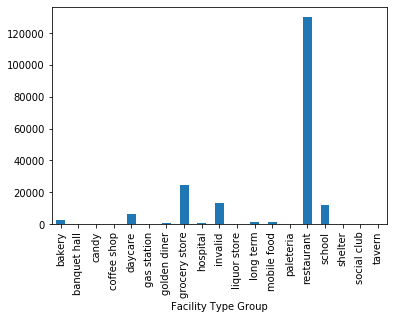

In [152]:
data.groupby('Facility Type Group').count()['DBA Name'].plot.bar()

## Inspection types
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

Inspection type: An inspection can be one of the following types: 
* canvass, the most common type of inspection performed at a frequency relative to the risk of the establishment; 
* consultation, when the inspection is done at the request of the owner prior to the opening of the establishment; complaint, when  the inspection is done in response to a complaint against the establishment; 
* license, when the inspection is done as a requirement for the establishment to receive its license to operate; 
* suspect food poisoning, when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint-based inspection); 
* task-force inspection, when an inspection of a bar or tavern is done. 

Re-inspections can occur for most types of these inspections and are indicated as such.

In [226]:
inspection_types = data['Inspection Type'].drop_duplicates().reset_index(drop=True).apply(str)
valid_inspection_types = ['canvass', 'consultation', 'license', 'complaint', 'food poisoning', 'task']
pd.set_option('display.max_rows', 108)
print(inspection_types[inspection_types.apply(str.lower).map(lambda x: any([y in x for y in valid_inspection_types]))])
print(inspection_types[inspection_types.apply(str.lower).map(lambda x: not any([y in x for y in valid_inspection_types]))])
pd.reset_option('display.max_rows')

# What to do? We could manually annotate them since there are not too many. 
# We also need to figure out what a combination of types mean, for example "License-Task Force"
# Also, there are a few things that are not correctly classified using only keywords, for example "OWNER SUSPENDED OPERATION/LICENSE" will be classified as license

0                          License Re-Inspection
1                        Complaint Re-Inspection
2                                        License
3                                        Canvass
4                          Canvass Re-Inspection
6                                      Complaint
7                           Short Form Complaint
8                       Suspected Food Poisoning
9         Suspected Food Poisoning Re-inspection
11                                  Consultation
15                                fire complaint
19                            License-Task Force
20                  Complaint-Fire Re-inspection
21                                Complaint-Fire
22                     Short Form Fire-Complaint
26                     LICENSE CANCELED BY OWNER
27             OWNER SUSPENDED OPERATION/LICENSE
28                          LICENSE CONSULTATION
29                          License consultation
30                        Task Force Liquor 1475
34                  

## Results
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

An inspection can pass, pass with conditions or fail. Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such. 

We add the categories 'not ready' and 'no entry', which covers all result types.

In [158]:
results = data['Results'].apply(str)
results_unique = data['Results'].drop_duplicates().reset_index(drop=True).apply(str)
valid_results_strings = ['pass','pass w/ conditions','fail','out of business', 'business not located', 'not ready', 'no entry']
print('Valid results')
print(results_unique[results_unique.apply(str.lower).map(lambda x: any([y == x for y in valid_results_strings]))])
print('Invalid results')
print(results_unique[results_unique.apply(str.lower).map(lambda x: not any([y == x for y in valid_results_strings]))])

Valid results
0                    Fail
1                    Pass
2               Not Ready
3      Pass w/ Conditions
4                No Entry
5         Out of Business
6    Business Not Located
Name: Results, dtype: object
Invalid results
Series([], Name: Results, dtype: object)


We see that the Results column is well-formed, and we do not have to format it.

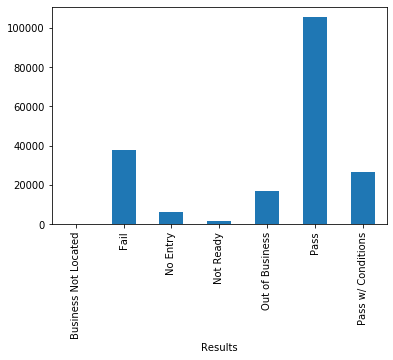

In [163]:
data.groupby('Results').count()['DBA Name'].plot.bar()

# Finding useful data in the Violations column
Violations seem to have the structure:
(&lt;violation number>. &lt;violation title> - &lt;violation comments> - | )+

According to https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF, critical violations are numbered 1-14, and serious violations are numbered 15-29. If these are found and fixed during the inspection, the inspection will pass with conditions. Otherwise it will fail.

In [247]:
data['Violations'][102762]

'18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: OBSERVED EVIDENCE OF LIVE FRUIT FLIES INSIDE PREMISES. OBSERVED LIVE FRUIT FLIES ON WALLS AND CEILING IN BASEMENT. APPROXIMATELY 40 LIVE FRUIT FLIES WERE OBSERVED IN THIS AREAS. MUST CLEAN AND SANITIZE  AFFECTED AREAS. ADDITIONAL PEST CONTROL SERVICE IS NEEDED TO MINIMIZE OR ELIMINATE THE PEST ACTIVITY. SERIOUS VIOLATIOM 7-38-020. | 29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-090 - Comments: PREVIOUS MINOR VIOLATIONS NOT CORRECTED FROM 09/09/13, REPORT#129655833. (33)OBSERVED THE FOLLOWING NOT CLEAN:INTERIOR OF CEILING,WALLS DOOR OF BASEMENT WALK IN COOLER,PREP COOLERS,ESPECIALLY THE HANDLES,DISH MACHINE,ALL FOOD EQUIPMENT ON 1ST FLOOR. 12/09/2013   (35) OPENINGS GOING DOWN WALL BEHIND DOOR LEADING TO BASEMENT.MUST SEAL TO PREVENT HIDING AREAS FOR PEST. SERIOUS VIOLATIONS NOT CORRECTED 7-42-090 | 30. FOOD IN ORIGINAL CONTAINER, PROPE

In [249]:
re_num = re.compile(r'([0-9]+)\.\s.*?\s\|')
violation_numbers = data['Violations'].apply(re_num.findall).apply(lambda xs: list(map(lambda x: int(x), xs)))
critical_violations = range(1,14+1)
serious_violations = range(15, 29+1)
violation_numbers
# Maybe we can actually connect violation numbers to result "Out of business"
# See under "Under what conditions will a food establishment get shut down?" https://dchealth.dc.gov/service/understanding-food-establishment-inspections
# While this is for Washington DC, I think it could apply to us too
# Also see "Results" in https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF

0                       [3, 5, 25, 50, 53, 53, 56]
1                                               []
2                                               []
3                                         [10, 55]
4                                         [54, 55]
                            ...                   
194899                                          []
194900                            [18, 32, 34, 35]
194901                                          []
194902    [18, 19, 32, 33, 34, 35, 36, 37, 38, 39]
194903                                          []
Name: Violations, Length: 194708, dtype: object

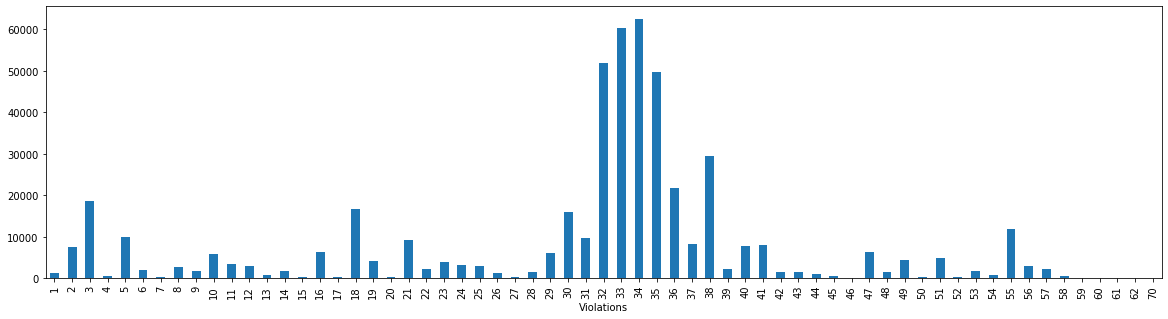

In [257]:
violation_numbers_exploded = violation_numbers.explode().dropna().sort_values()
violation_numbers_exploded.groupby(violation_numbers_exploded).count().plot.bar(figsize=(20,5))

In [258]:
violations_severity = violation_numbers.apply(lambda xs: list(map(lambda x: 'critical' if x in critical_violations else 'serious' if x in serious_violations else 'non-serious', xs)))
violations_severity = violations_severity.apply(lambda xs: ['no violation'] if len(xs) == 0 else xs)
violations_severity

0         [critical, critical, serious, non-serious, non...
1                                            [no violation]
2                                            [no violation]
3                                   [critical, non-serious]
4                                [non-serious, non-serious]
                                ...                        
194899                                       [no violation]
194900     [serious, non-serious, non-serious, non-serious]
194901                                       [no violation]
194902    [serious, serious, non-serious, non-serious, n...
194903                                       [no violation]
Name: Violations, Length: 194708, dtype: object

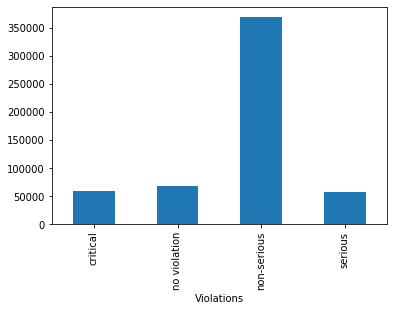

In [253]:
violations_severity_exploded = violations_severity.explode()
violations_severity_exploded.groupby(violations_severity_exploded).count().plot.bar()

# Supplementing the data

## Income by zip code (actually, anything by zip code if we want)
https://towardsdatascience.com/getting-census-data-in-5-easy-steps-a08eeb63995d

Attribution statement: This product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

Zip code 60666 is the zip code for O'Hare International Airport.
Zip code 60627 is the zip code for Golden Gate Park.
These do not have a household median income since nobody lives there.

In [429]:
incomes = []
income_by_zip_address = "https://api.census.gov/data/%s/acs/acs5?key=%s&get=%s&for=zip%%20code%%20tabulation%%20area:%s" 
year = "2017" # 2009-2017
api_key = "" # Request here: https://www.census.gov/developers/
income_variable = "B19013_001E"
zip_codes = data['Zip'].drop_duplicates()

for zip_code in zip_codes:
    if pd.isnull(zip_code):
        continue
        
    called_api = income_by_zip_address % (year, api_key, income_variable, int(zip_code))
    response = requests.get(called_api)
    if response.status_code == 200:
        formatted_response = json.loads(response.text)
        print(formatted_response)
        incomes.append(formatted_response)
    else:
        print('Could not find income for zip code: ' + str(int(zip_code)))
    # add to some list or something, also exception handling
    

KeyboardInterrupt: 

In [169]:
# chicago_map = gpd.read_file('data/chicago_zip.shp') # https://www.kaggle.com/threadid/chicago-shape-files

In [170]:
# ax = chicago_map.plot()
# g_data.plot(ax=ax, color='red')

In [226]:
with open('data/income_data.pkl', 'wb') as f:
    pickle.dump(incomes, f)

In [190]:
print(incomes[0][1])

['63106', '60625']


In [430]:
zip_inc = [zi[1]for zi in incomes  ]
print(zip_inc)

In [360]:
dict_inc = {"Income":[int(i[0]) for i in zip_inc], "Zip":[i[1] for i in zip_inc] }
econ_data = pd.DataFrame (dict_inc, columns = ["Income", "Zip"])

In [431]:
#econ_data.head(5)

In [432]:
econ_data.sort_values("Income", ascending = False)

# Projecting information on a map

## Coordinates
We want to be able to visualize our dataset on a map based on coordinates. This is done by using Folium.

In [207]:
data_names = data.groupby('DBA Name').first()
data_names.head()


Inspection ID  License #  Facility Type  \
DBA Name                                                                
#1 CHINA EXPRESS, LTD.            1285263.0  1869616.0     Restaurant   
#1 CHOP SUEY                      2283095.0  1970042.0     Restaurant   
#1 CHOP SUEY RESTAURANT            539348.0  1739799.0     Restaurant   
#1 CHOP SUEY RESTAURANT, INC      2320233.0  2695112.0     Restaurant   
#1 DELI                           2312319.0  2657753.0  Grocery Store   

                                       Risk                  Address      Zip  \
DBA Name                                                                        
#1 CHINA EXPRESS, LTD.        Risk 1 (High)     4248 S WENTWORTH AVE  60609.0   
#1 CHOP SUEY                  Risk 1 (High)    4307 W IRVING PARK RD  60641.0   
#1 CHOP SUEY RESTAURANT       Risk 1 (High)    4307 W IRVING PARK RD  60641.0   
#1 CHOP SUEY RESTAURANT, INC  Risk 1 (High)  7342 S STONY ISLAND AVE  60649.0   
#1 DELI                       Risk 1 (High)       6901 S NORMAL BLVD  60621.0   

                                      Inspection Date Inspection Type  \
DBA Name                                                                
#1 CHINA EXPRESS, LTD.        2012-09-14T00:00:00.000         Canvass   
#1 CHOP SUEY                  2019-04-12T00:00:00.000       Complaint   
#1 CHOP SUEY RESTAURANT       2011-07-01T00:00:00.000         Canvass   
#1 CHOP SUEY RESTAURANT, INC  2019-10-22T00:00:00.000         License   
#1 DELI                       2019-09-16T00:00:00.000         License   

                                         Results  \
DBA Name                                           
#1 CHINA EXPRESS, LTD.           Out of Business   
#1 CHOP SUEY                  Pass w/ Conditions   
#1 CHOP SUEY RESTAURANT          Out of Business   
#1 CHOP SUEY RESTAURANT, INC                Pass   
#1 DELI                       Pass w/ Conditions   

                                                                     Violations  \
DBA Name                                                                          
#1 CHINA EXPRESS, LTD.        30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...   
#1 CHOP SUEY                  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
#1 CHOP SUEY RESTAURANT                                                     NaN   
#1 CHOP SUEY RESTAURANT, INC                                                NaN   
#1 DELI                       3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   

                               Latitude  Longitude  
DBA Name                                            
#1 CHINA EXPRESS, LTD.        41.816834 -87.631346  
#1 CHOP SUEY                  41.953443 -87.735763  
#1 CHOP SUEY RESTAURANT       41.953443 -87.735763  
#1 CHOP SUEY RESTAURANT, INC  41.761138 -87.586346  
#1 DELI                       41.768866 -87.637095

In [208]:
print(len(data_names[data_names['Zip'].apply(pd.isnull)]))

0


In [209]:
middle_lat = data_names.Latitude.median()
middle_lon = data_names.Longitude.median()
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)
locations = folium.map.FeatureGroup()
lats = data_names.Latitude
lons = data_names.Longitude
names = data_names.index


for lat, lon, name in list(zip(lats, lons, names))[0:10]:
    if np.isnan(lat) or np.isnan(lon):
        continue
    folium.Marker(
        location =  [lat, lon],
        tooltip = name,
        icon = folium.Icon(color='green', icon='info-sign')
    ).add_to(ch_map)
    
ch_map.add_child(locations)
print("Done")

Done


## Zip code areas
We use the zip code boundaries in a GeoJSON format from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw. We then simply overlay them on the map.

In [224]:
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)

data_zip = data.groupby('Zip').count().reset_index()[['Zip', 'Risk']].rename(columns={'Risk':'Count'})
data_zip['Zip'] = data_zip['Zip'].apply(int).apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=map_zip, #was data_zip before but that contians zip codes outside of the city
    columns=['Zip', 'Count'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of inspections per Zip',
)

folium.GeoJsonTooltip(["Count"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

#folium.LayerControl().add_to(ch_map)
ch_map

132 is quite low, is there something special about that Zip code

Can use this setup to calculate other things like the pass rate for inspections

In [289]:
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)

data_zip = econ_data
data_zip['Zip'] = data_zip['Zip'].apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=map_zip, #was data_zip before but that contians zip codes outside of the city
    columns=['Zip', 'Income'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Income per Zip',
)

folium.GeoJsonTooltip(["Income"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

ch_map

In [221]:
data[data["Zip"] ==60022.0] #outside of the city

Inspection ID       DBA Name  License #  \
160938       635185.0  SWEET CASSAVA  2125364.0   

                          Facility Type           Risk       Address      Zip  \
160938  Shared Kitchen User (Long Term)  Risk 1 (High)  350 WOODLAWN  60022.0   

                Inspection Date Inspection Type Results Violations  Latitude  \
160938  2011-11-02T00:00:00.000         License    Pass        NaN  41.78046   

        Longitude  
160938  -87.60135

In [228]:
data.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located        66
Fail                     37669
No Entry                  6179
Not Ready                 1859
Out of Business          16763
Pass                    105427
Pass w/ Conditions       26743
Name: Count, dtype: int64

In [236]:
data_fails = data[data['Results'] == "Fail"]
data_passes = data[(data['Results'] == "Pass") | (data['Results'] == "Pass w/ Conditions")]
#data.groupby(['Results', 'Zip']).count().rename(columns={"DBA Name": "Count"})["Count"]
print("Number of Fails: ",len(data_fails), ", Number of Passes:", len(data_passes))

Number of Fails:  37669 , Number of Passes: 132170


Calculating the failure rate per Zip code

In [255]:
dfc = data_fails.groupby(['Zip']).count().rename(columns={"DBA Name": "Count"})["Count"]
dpc = data_passes.groupby(['Zip']).count().rename(columns={"DBA Name": "Count"})["Count"]
dpc.head()

Zip
10014.0     1
53061.0     1
60007.0    10
60015.0     2
60018.0     2
Name: Count, dtype: int64

In [279]:
failure_rate = dfc/(dfc+dpc)

In [362]:
fr = pd.DataFrame(failure_rate).reset_index()

In [363]:
fr.columns

Index(['Zip', 'Count'], dtype='object')

In [286]:
fr

Zip     Count
0    10014.0       NaN
1    46319.0       NaN
2    53061.0       NaN
3    60007.0  0.230769
4    60015.0       NaN
..       ...       ...
105  60714.0       NaN
106  60803.0  0.333333
107  60804.0  0.166667
108  60805.0  0.333333
109  60827.0  0.227642

[110 rows x 2 columns]

In [288]:
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)

data_zip = fr
data_zip['Zip'] = data_zip['Zip'].apply(int).apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=map_zip, #was data_zip before but that contians zip codes outside of the city
    columns=['Zip', 'Count'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of inspections per Zip',
)

folium.GeoJsonTooltip(["Count"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

#folium.LayerControl().add_to(ch_map)
ch_map

In [364]:
econ_data['Zip'] = econ_data['Zip'].apply(str)

In [365]:
fr['Zip'] = fr['Zip'].apply(int).apply(str)

Calculating failure rate per dollar of income.

In [367]:
econ_data = econ_data.set_index(['Zip'])#frpdi = fr/econ_data

In [368]:
econ_data = econ_data.rename(columns={'Income':'Count'})

In [369]:
fr = fr.set_index("Zip")

In [433]:
#econ_data

In [371]:
econ_norm = econ_data / (econ_data.max())

In [435]:
#econ_norm

In [373]:
frpdi = fr/(econ_norm)

In [374]:
frpdi

Count
Zip            
10014       NaN
46319       NaN
53061       NaN
60007  0.645033
60015       NaN
...         ...
60714       NaN
60803  1.322719
60804  0.771246
60805  1.008259
60827  1.498513

[112 rows x 1 columns]

In [375]:
frpdi = pd.DataFrame(frpdi).reset_index()

In [376]:
frpdi

Zip     Count
0    10014       NaN
1    46319       NaN
2    53061       NaN
3    60007  0.645033
4    60015       NaN
..     ...       ...
107  60714       NaN
108  60803  1.322719
109  60804  0.771246
110  60805  1.008259
111  60827  1.498513

[112 rows x 2 columns]

In [338]:
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)

data_zip = frpdi
#data_zip['Zip'] = data_zip['Zip'].apply(int).apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=map_zip, #was data_zip before but that contians zip codes outside of the city
    columns=['Zip', 'Count'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of inspections per Zip',
)

folium.GeoJsonTooltip(["Count"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

#folium.LayerControl().add_to(ch_map)
ch_map

In [339]:
import matplotlib.pyplot as plt

In [402]:
map_zip = gpd.read_file('data/chicago_zip.geojson')
econ_chic = map_zip.merge(econ_data, left_on='zip', right_on='Zip')
econ_chic = econ_chic[["Count","zip"]]

In [403]:
#econ_chic

In [404]:
map_zip = gpd.read_file('data/chicago_zip.geojson')
fr_chic = map_zip.merge(fr, left_on='zip', right_on='Zip')
fr_chic = fr_chic[["Count","zip"]]

In [405]:
fr_chic.head()

Count    zip
0  0.242189  60647
1  0.256084  60639
2  0.225664  60707
3  0.225664  60707
4  0.237237  60622

In [406]:
econ_chic = econ_chic.set_index("zip")
fr_chic = fr_chic.set_index("zip")

In [407]:
fr_chic.sort_index(inplace=True)
econ_chic.sort_index(inplace=True)

In [436]:
#econ_chic["Count"]

In [411]:
fr_chic

Count
zip            
60601  0.136333
60602  0.153077
60603  0.159791
60604  0.142358
60605  0.185657
...         ...
60661  0.171384
60666  0.136659
60707  0.225664
60707  0.225664
60827  0.227642

[61 rows x 1 columns]

In [416]:
econ_chic2 = econ_chic.rename(columns={'Count':'Count_econ'})

In [437]:
#econ_chic2

In [420]:
fr_chic2 =fr_chic.copy()

In [424]:
merge = fr_chic2.join(econ_chic2,how='inner')

In [438]:
#merge

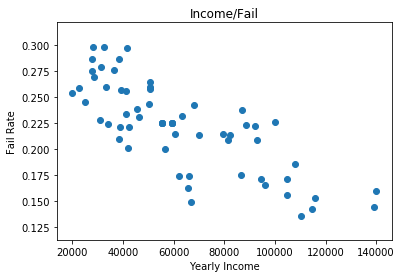

In [428]:
plt.scatter(merge["Count_econ"].to_list(), merge["Count"].to_list())
plt.title('Income/Fail')
plt.xlabel('Yearly Income')
plt.ylabel('Fail Rate')
plt.show()

TODO: regression analysis, other analysis like number of unique restaurants to zip code income ...